In this homework, you need to solve four tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). Overall, there are 23 points, however, you can get a maximum of 20 points for this assignment( `your_points = min(your_points, 20)`). No bonus points will be transferred to the next assignment.

# Task 1. Non-parametric Density Estimation (6 points)

In [1]:
import numpy as np
import numpy.linalg as nla
import scipy
import scipy.stats as sps
import pandas as pd

from statsmodels.nonparametric.kernel_regression import KernelReg

In [2]:
# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# non-interactive
%matplotlib inline

#jupyterlab
# %matplotlib widget 

#jupyter-notebook
# %matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset']='cm'
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

You will work with data sampled from the mixture of Normal distributions:

In [3]:
seed1 = 31337
seed2 = 42
n_samples = 100

f1 = scipy.stats.norm(loc=0, scale=1)
f2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1

Xa = f1.rvs(size=int(p1 * n_samples), random_state=seed1)
Xb = f2.rvs(size=int(p2 * n_samples), random_state=seed2)
samples = np.concatenate([Xa, Xb])

a = -5
b = 10

x_values = np.linspace(a, b, 1000)
binedges = np.linspace(a, b, 10)
true_pdf = p1 * f1.pdf(x_values) + p2 * f2.pdf(x_values)

## Histogram estimate

$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\xs}[1]{\boldX^{(#1)}}$
$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\hatp}{\widehat{p}}$
$\newcommand{\hatJ}{\widehat{J}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

Given a sample $\boldsymbol{X}^{(n)} = \boldsymbol{X}_1, \boldsymbol{X}_2, ..., \boldsymbol{X}_n \sim \; iid \; p(x)$ we would like to build a hitogram estimate of the density. If we have $m$ bins of size $h$, we can have the following estimates of risk using leave-one-out cross validation:

\begin{gather*}
J(h) = \int \hatp^2\lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx, 
\end{gather*}
\begin{gather*}
\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp, \label{eq1}\tag{1}
\end{gather*}
\begin{gather*}
\hatJ(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n}. \label{eq2}\tag{2}
\end{gather*}

Your task is:
1. Build a histogram estimate of the pdf given the sample above, tune bandwidth using leave-one-out CV based on $\hatJ$. Use formula (\ref{eq2}) (1 point)
2. \* Prove that for histograms (\ref{eq2}) follows from (\ref{eq1}) (1 bonus point)
3. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$ (0.5 point)
4. Recall the approximation to $MISE$ from Lecture 8, slide 20. Suppose that an Oracle calculated the integral of the squared derivative of the true density for you and the value is $0.0804924$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)
5. `np.histogram` has some built-in methods of selecting bandwidth. Compare some of them with your CV result and theoretical approximation (again, using CV estimate of $J$) (1 point)

In [4]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = int((sample_max - sample_min) / h)
    summ = 0
    deltas = [[sample_min + (i - 1) * h, sample_min + i * h] for i in range(1, bins+1)]
    for l, r in deltas:
        nu = np.sum([1 if l <= v <= r else 0 for v in sample])
        summ += (nu / n)**2
    
    return 2 / ((n - 1) * h) - (n + 1) / ((n - 1) * h) * summ

### 3)

In [5]:
h_list = np.logspace(-1, 1, 100)
cv_hist = [cross_validation_histogram(samples, hi) for hi in h_list]

In [6]:
h_cv = h_list[np.argmin(cv_hist)]

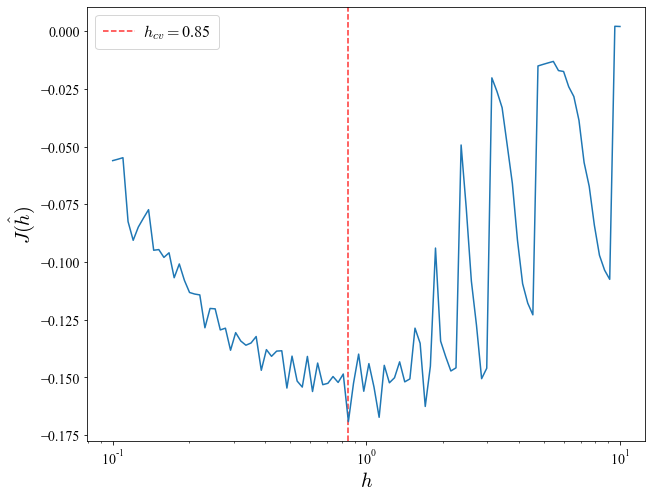

J(h)= -0.17


In [7]:
plt.figure(figsize=(10, 8))
plt.axvline(h_cv, c='r', linestyle='--', alpha=0.8, label=r'$h_{cv}=$'f'{h_cv:.2f}')

plt.plot(h_list, cv_hist)

plt.xscale("log")
plt.xlabel(r'$h$', fontsize=20)
plt.ylabel(r'$\hat{J(h)}$', fontsize=20)

plt.legend()
plt.show()

print(f'J(h)= {min(cv_hist):.2f}')

### 1)

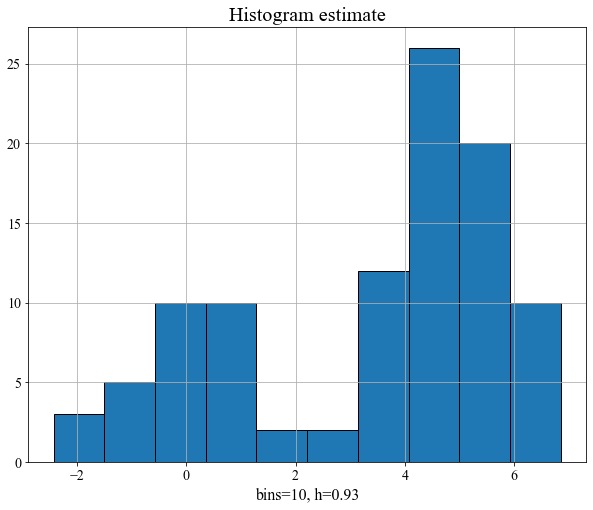

In [8]:
sample_min, sample_max = np.min(samples), np.max(samples)
bins = int((sample_max - sample_min) / h_cv)
delta = sample_max - sample_min

plt.figure(figsize=(10, 8))

plt.hist(samples, bins=bins, edgecolor='black')

plt.title('Histogram estimate')
plt.xlabel(f"bins={bins}, h={delta / bins:.2f}")
plt.grid()
plt.show()

### 4)

In [9]:
sqr_int = 0.0804924

In [10]:
h_mise = samples.shape[0] ** (-1/3) * (6/sqr_int)**(1/3)
h_mise

0.9067038459825565

In [11]:
cv_estimate = cross_validation_histogram(samples, h_mise)
print(f'J(h)= {cv_estimate:.2f}')

J(h)= -0.15


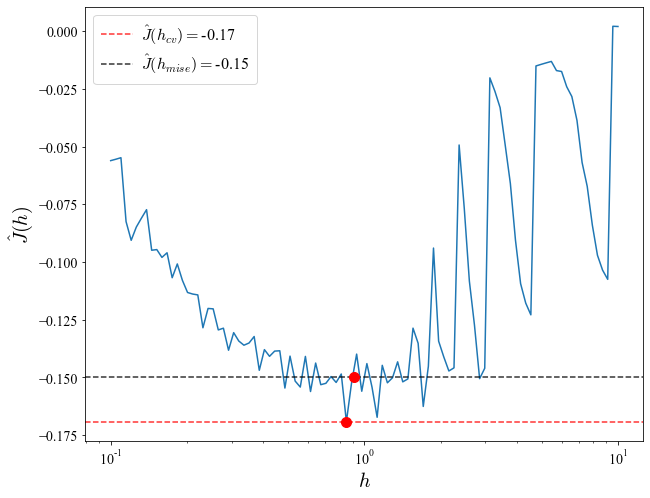

In [12]:
plt.figure(figsize=(10, 8))

plt.plot(h_list, cv_hist)

plt.axhline(min(cv_hist), c='r', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{cv})=$'f'{min(cv_hist):.2f}')

plt.axhline(cv_estimate, c='k', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{mise})=$'f'{cv_estimate:.2f}')

plt.plot(h_mise, cv_estimate, 'ro', markersize='10')
plt.plot(h_cv, min(cv_hist), 'ro', markersize='10')

plt.xscale("log")
plt.xlabel(r'$h$', fontsize=20)
plt.ylabel(r'$\hat{J}(h)$', fontsize=20)

plt.legend()
plt.show()

### 5)

In [13]:
bins_list = ['auto',
             'fd',
             'doane',
             'scott',
             'stone',
             'rice',
             'sturges',
             'sqrt']

In [14]:
numpy_risk=1e3

for b in bins_list:
    _, bin_edges = np.histogram(samples, bins=b)
    h_temp = bin_edges[1] - bin_edges[0]
    
    j = cross_validation_histogram(samples, h_temp)
    if j < numpy_risk:
        h_numpy = h_temp
    numpy_risk = min(j, numpy_risk)
    
h_numpy

0.8438641749766846

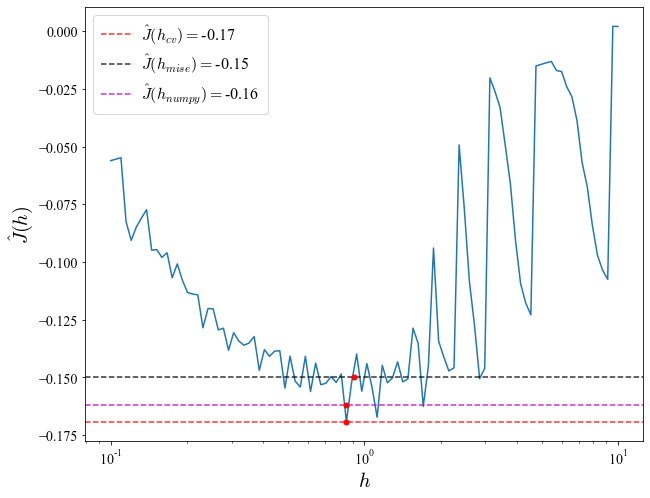

In [15]:
plt.figure(figsize=(10, 8))

plt.plot(h_list, cv_hist)

plt.axhline(min(cv_hist), c='r', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{cv})=$'f'{min(cv_hist):.2f}')

plt.axhline(cv_estimate, c='k', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{mise})=$'f'{cv_estimate:.2f}')

plt.axhline(numpy_risk, c='m', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{numpy})=$'f'{numpy_risk:.2f}')

plt.plot(h_mise, cv_estimate, 'ro', markersize='5')
plt.plot(h_cv, min(cv_hist), 'ro', markersize='5')
plt.plot(h_numpy, numpy_risk, 'ro', markersize='5')

plt.xscale("log")
plt.xlabel(r'$h$', fontsize=20)
plt.ylabel(r'$\hat{J}(h)$', fontsize=20)

plt.legend()
plt.show()

## Kernel density estimate

In this part, you will use the same sample, but employ the kernel density estimation method. We can use the same proxy expression to optimise the risk:
\begin{gather*}
J(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx
\end{gather*}

In out case of kernel estimator, we can obtain:
\begin{gather*}
\hatJ(h) = \frac{1}{hn^2}\Sum_{i = 1}^n\Sum_{j = 1}^n K^{(2)}\lp\frac{x_i - x_j}{h}\rp + \frac{2K(0)}{nh}, \label{eq3}\tag{3}
\end{gather*}
where
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

You can use [kernel density estimation from sklearn](http://scikit-learn.org/stable/modules/density.html). Your task is:
1. Build a kernel density estimate given the sample from before, tune bandwidth using leave-one-out CV. Try two different kernels of your choice. Use formula \ref{eq3} in your tuning procedure (1 point)
2. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$. What kernel worked better in terms of estimated surrogate risk? (0.5 point)
3. Recall the approximation to $MISE$ from Lecture 8, slide 11. Suppose that an Oracle calculated the integral of the squared second derivative of the true density for you and the value is $0.127529$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

In [16]:
from sklearn.neighbors import KernelDensity

### 1)

In [4]:
def cross_validation_kernel(sample, h, K, K_conv):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    
    summ = 0
    for i in range(sample.shape[0]):
        for j in range(sample.shape[0]):
            arg = (sample[i] - sample[j]) / h
            summ += K_conv(arg) - 2 * K(arg)
    
    return 1 / (h * n**2) * summ + 2 * K(0) / (n * h)

In [5]:
def sigmoid_kernel(x):
    return 2 / (np.exp(x) + np.exp(-x)) / np.pi

def sigmoid_kernel_conv(x):
    return np.exp(-x) / np.pi

### 2)

In [3]:
h_list = np.logspace(-1, 1, 100)
cv_hist = [cross_validation_kernel(samples, hi, sigmoid_kernel, sigmoid_kernel_conv) for hi in h_list]

NameError: name 'np' is not defined

In [20]:
h_cv = h_list[np.argmin(cv_hist)]

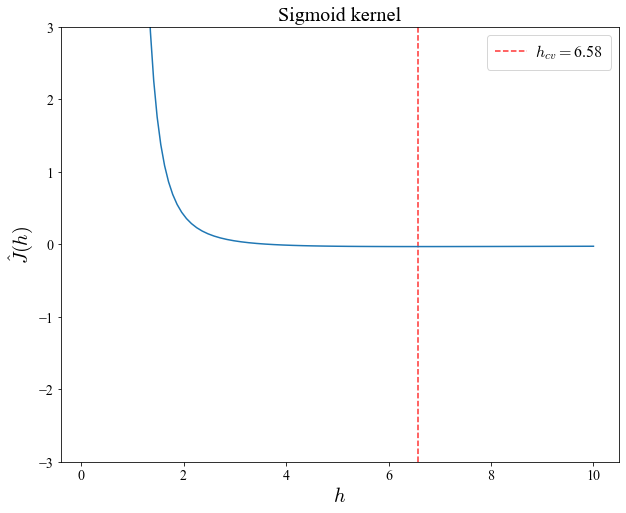

J(h)= -0.03


In [21]:
plt.figure(figsize=(10, 8))
plt.axvline(h_cv, c='r', linestyle='--', alpha=0.8, label=r'$h_{cv}=$'f'{h_cv:.2f}')

plt.plot(h_list, cv_hist)

plt.xlabel(r'$h$', fontsize=20)
plt.ylabel(r'$\hat{J}(h)$', fontsize=20)
plt.title('Sigmoid kernel')

plt.ylim([-3, 3])

plt.legend()
plt.show()

print(f'J(h)= {min(cv_hist):.2f}')


In [22]:
def gaussian_kernel(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

def gaussian_kernel_conv(x):
    return 1 / (2 * np.pi) * np.exp(-x**2 / 4)

In [23]:
h_list = np.logspace(-1, 1, 100)
cv_hist = [cross_validation_kernel(samples, hi, gaussian_kernel, gaussian_kernel_conv) for hi in h_list]

In [24]:
h_cv = h_list[np.argmin(cv_hist)]

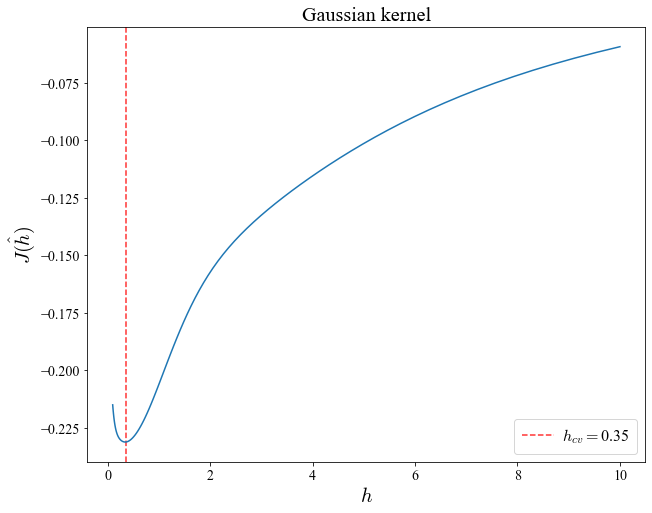

J(h)= -0.23


In [25]:
plt.figure(figsize=(10, 8))
plt.axvline(h_cv, c='r', linestyle='--', alpha=0.8, label=r'$h_{cv}=$'f'{h_cv:.2f}')

plt.plot(h_list, cv_hist)

plt.xlabel(r'$h$', fontsize=20)
plt.ylabel(r'$\hat{J(h)}$', fontsize=20)
plt.title('Gaussian kernel')

plt.legend()
plt.show()

print(f'J(h)= {min(cv_hist):.2f}')

**Conclusion:** Gaussian kernel works better due to $\hat{J}(h)$ value.

### 3)

For Gaussian kernel:

$$h^{*}=\left(\frac{1}{n} \frac{\int(K(x))^{2} d x}{\left(\int x^{2} K(x) d x\right)^{2}\left(\int p^{\prime \prime}(x)^{2} d x\right)}\right)^{\frac{1}{5}} = \left(\frac{1}{n} \frac{\frac{1}{2\sqrt{\pi}}}{\sigma_{K}^{4}\cdot 0.127529}\right)^{\frac{1}{5}}$$

In [26]:
sqr_int = 0.127529

In [27]:
def gaussian_kernel_sqr():
    return 1 / (2 * np.sqrt(np.pi))

In [28]:
h_mise = (1 / samples.shape[0] * gaussian_kernel_sqr() / (np.var(samples)**2 * sqr_int))**(1/5)
h_mise

0.23175066240462766

In [29]:
cv_estimate = cross_validation_histogram(samples, h_mise)
print(f'J(h)= {cv_estimate:.2f}')

J(h)= -0.11


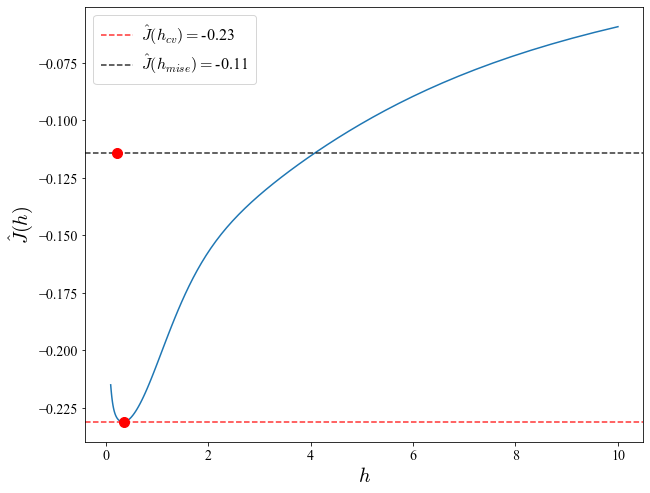

In [30]:
plt.figure(figsize=(10, 8))

plt.plot(h_list, cv_hist)

plt.axhline(min(cv_hist), c='r', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{cv})=$'f'{min(cv_hist):.2f}')

plt.axhline(cv_estimate, c='k', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{mise})=$'f'{cv_estimate:.2f}')

plt.plot(h_mise, cv_estimate, 'ro', markersize='10')
plt.plot(h_cv, min(cv_hist), 'ro', markersize='10')

plt.xlabel(r'$h$', fontsize=20)
plt.ylabel(r'$\hat{J}(h)$', fontsize=20)

plt.legend()
plt.show()

# Task 2. Non-parametric Regression (5.5 pt)

In this task you will apply non-parametric regression to airport statistics data.

### Data loading and preprocessing

Load dataset from `airport_operations_report.csv`. Use `General Aviation: Total Operations` as target (dependent) variable and `[Air Carrier Operations, General Aviation: Local Operations]` as covariates(independent variables). Divide $1^{st}$ covariate by `1000`, $2^{nd}$ by `100` and target by `1000`. Make a 2D grid for covariates from minimum to maximum values with `100` steps along each dimension.

In [31]:
import warnings

warnings.filterwarnings("ignore")

In [32]:
df = pd.read_csv('airport_operations_report.csv')
df.head(5)

,Air Carrier Operations,General Aviation: Local Operations,General Aviation: Total Operations
0,10329.0,4.0,2219.0
1,10593.0,28.0,3312.0
2,11320.0,56.0,3310.0
3,11936.0,0.0,3382.0
4,11726.0,256.0,4242.0


In [33]:
covariates = df[['Air Carrier Operations', 'General Aviation: Local Operations']]
covariates['Air Carrier Operations'] = covariates['Air Carrier Operations'].div(1000)
covariates['General Aviation: Local Operations'] = covariates['General Aviation: Local Operations'].div(100)

covariates.head(5)

,Air Carrier Operations,General Aviation: Local Operations
0,10.329,0.04
1,10.593,0.28
2,11.320,0.56
3,11.936,0.00
4,11.726,2.56


In [34]:
target = df[['General Aviation: Total Operations']].div(1000)

target.head(5)

,General Aviation: Total Operations
0,2.219
1,3.312
2,3.310
3,3.382
4,4.242


### Fit model (1 pt)

Perform a nonparametric regression to fit the model $Y = f(x)+\varepsilon$.

In [35]:
l1 = np.linspace(covariates['Air Carrier Operations'].min(), covariates['Air Carrier Operations'].max(), 100)
l2 = np.linspace(covariates['General Aviation: Local Operations'].min(), covariates['General Aviation: Local Operations'].max(), 100)

In [36]:
kernel_reg = KernelReg(target.values,
                       covariates.values,
                       var_type="cc", reg_type="lc")
kernel_reg

KernelReg instance
Number of variables: k_vars = 2
Number of samples:   N = 117
Variable types:      cc
BW selection method: cv_ls
Estimator type: lc

Predict values for the created grid.

In [37]:
step_numbers = (100, 100)

grid = np.zeros([l1.shape[0], l1.shape[0], 2])

target_pred = np.zeros([l1.shape[0], l1.shape[0]])

for i in range(l1.shape[0]):
    for j in range(l2.shape[0]):
        tmp = np.array([l1[i], l2[j]])
        target_pred[i, j] = kernel_reg.fit(tmp)[0][0]
        grid[i, j] = tmp

target_pred = target_pred.reshape(*step_numbers)
grid = grid.reshape(*step_numbers, 2)
grid.shape

(100, 100, 2)

In [38]:
target_pred.shape

(100, 100)

This is function to visualize 3D surfaces. You can modify it if you need.

In [39]:
def plot_surface_function(x1, x2, y, minmax_values=None, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
    
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.1, edgecolor="k")
        
    return ax

Let's plot the estimated surface.

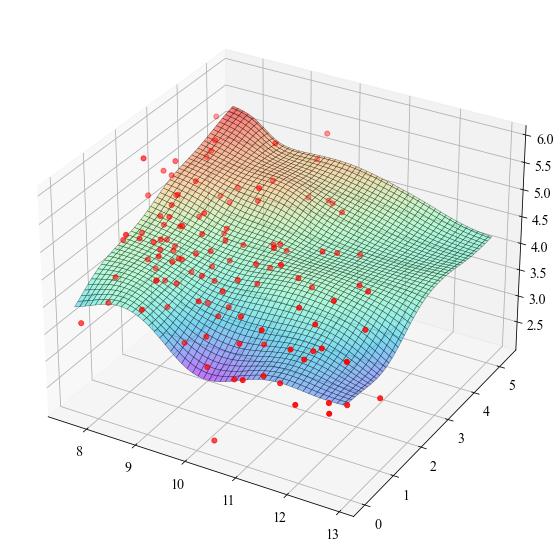

In [40]:
# target - dependent variable
# grid - grid for covariates
sample = covariates.values

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred)
ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r")

### Estimate confidence intervals (2 pt)

Construct 95\% confidence bands for your estimate. To estimate error variance for 1D covariate, you sort your sample and subtract target values of the nearest points. For 2D covariate, you should, for each point, calculate the difference in target values between a point and its nearest neighbor (in euclidian metric). 

To get power for quantile of the standard normal distribution, which is $\frac{h}{b-a}$ for 1D, estimate it per coordinate and multiply: $\prod_{i=1}^2 \frac{h_i}{b_i-a_i}$. 

For gaussian kernal $h = 3 \times$ kernel_bandwidth.

In [41]:
from sklearn.metrics.pairwise import rbf_kernel

In [42]:
kernel = lambda x, y, h: rbf_kernel(
    x[:, 0].reshape((x[:, 0].shape[0], 1)),
    y[:, 0].reshape((y[:, 0].shape[0], 1)),
    0.5 / h[0]**2
) / (2 * np.pi)**(1.0 / 2) * rbf_kernel(
    x[:, 1].reshape((x[:, 1].shape[0], 1)),
    y[:, 1].reshape((y[:, 1].shape[0], 1)),
    0.5 / h[1]**2) / (2 * np.pi)**(1.0 / 2)

In [43]:
x, y = np.zeros(2), np.ones(2)
nla.norm(x-y)

1.4142135623730951

In [44]:
def prediction_se(grid, sample, target, h, kernel_reg, alpha=0.05):

    n = target.shape[0]
    sigma_hat2 = 0.
    
    mask = np.ones(n, dtype=int)
    
    for s_id, samp in enumerate(sample):
        
        mask[s_id] = False
        min_dist = np.inf
        min_ngb = None
        
        for ngb in sample[mask]:
            dist = nla.norm(samp - ngb)
            if dist < min_dist:
                min_dist = min(min_dist, dist)
                min_ngb = ngb
                
        mask[s_id] = True
        
        sigma_hat2 += (kernel_reg.fit(samp)[0] - kernel_reg.fit(min_ngb)[0]) ** 2 
        
    sigma_hat2 /= (2 * (n-1))
    
    delta1 = np.max(sample[:, 0]) - np.min(sample[:, 0])
    delta2 = np.max(sample[:, 1]) - np.min(sample[:, 1])
    
    kernel_values = kernel(grid, sample, h)
    kernel_sum = np.sum(kernel_values, axis=1, keepdims=True)
#     print(kernel_values)

    nonzero_indices = kernel_sum[:, 0] > 1e-8
    kernel_weights = kernel_values
    kernel_weights[nonzero_indices] = kernel_weights[nonzero_indices] / kernel_sum[nonzero_indices]
    kernel_weights[~nonzero_indices] = 0

    se = np.sqrt(np.sum(kernel_weights**2, axis=1) * sigma_hat2)
    m1, m2 = delta1 / (3.0 * h[0]), delta2 / (3.0 * h[1])
    q = sps.norm.ppf((1+(1-alpha)**(1.0/(m1 * m2)))/2)
    return q*se

In [45]:
qse = prediction_se(grid.reshape((10000, 2)),
                    sample,
                    target,
                    kernel_reg.bw,
                    kernel_reg,
                    alpha=0.05).reshape((100, 100))
qse.shape

(100, 100)

Let's plot confidence intervals

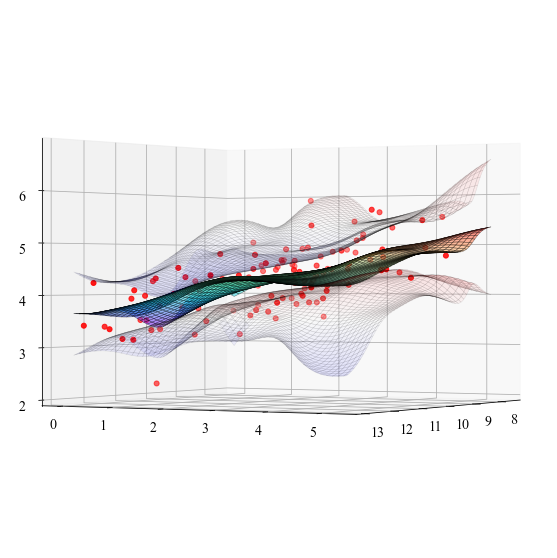

In [46]:
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred)
ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r")
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred + qse, ax=ax)
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred - qse, ax=ax)

ax.view_init(0, 30)

### Find optimal bandwidth (2 pt)

Use cross-validation to estimate the bandwidth.

In [47]:
sample.shape

(117, 2)

In [48]:
print('sample:', sample.shape)
print('target:', target.shape)

sample: (117, 2)
target: (117, 1)


In [49]:
n = sample.shape[0]
a = np.ones([n, n], dtype=np.bool_)
a.shape

(117, 117)

In [50]:
def cross_validation_regression(sample, target, h):
    n = sample.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    bw = np.r_[h]
    summ = 0
    for i in range(n):
#         for j in range(n):
        mask[i] = False
        nw = KernelReg(target[mask], sample[mask], var_type="cc", reg_type="lc", bw=bw)
        mask[i] = True
        summ += (target[i] - nw.fit(sample[i])[0])**2
    return summ.item()

Make a grid with logarithmic scale to find best bandwidth, from `0.1` to `10` with `21` steps along each dimension. Visualize the obtained results with `plot_surface_function`. Print values of optimal bandwidth.

In [51]:
target = target.values.squeeze()

In [52]:
h_grid = np.logspace(-1, 2, 21)
DIM = h_grid.shape[0]
cv_hist = np.zeros((DIM, DIM))
grid = np.zeros((DIM, DIM, 2))

for i in range(DIM):
    for j in range(DIM):
        tmp = np.array([h_grid[i], h_grid[j]])
        cv_hist[i, j] = cross_validation_regression(sample, target, tmp)
        grid[i, j] = tmp

# grid = grid.reshape(*step_numbers, 2)
grid.shape

(21, 21, 2)

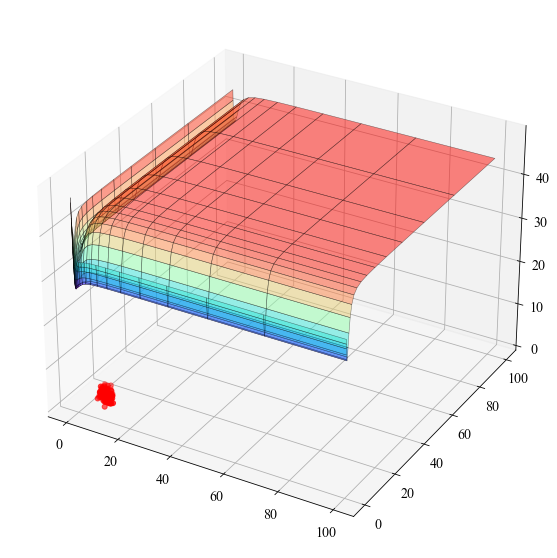

In [53]:
# target - dependent variable
# grid - grid for covariates
sample = covariates.values

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], cv_hist)
ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r")

In [54]:
min_id = np.argmin(cv_hist)
min_id

110

In [55]:
bw = grid[min_id // DIM, min_id % DIM]

cv_estimate = cv_hist[min_id // DIM, min_id % DIM]
print(f'J(h)= {cv_estimate:.2f}')
print(f'h= {bw}')

J(h)= 27.32
h= [0.56234133 0.56234133]


Plot surface with estimated bandwidth.

In [56]:
kernel_reg = KernelReg(target,
                       covariates,
                       var_type="cc", reg_type="lc",
                      bw=bw)
kernel_reg

KernelReg instance
Number of variables: k_vars = 2
Number of samples:   N = 117
Variable types:      cc
BW selection method: user-specified
Estimator type: lc

In [57]:
step_numbers = (100, 100)

grid = np.zeros([l1.shape[0], l1.shape[0], 2])

target_pred = np.zeros([l1.shape[0], l1.shape[0]])

for i in range(l1.shape[0]):
    for j in range(l2.shape[0]):
        tmp = np.array([l1[i], l2[j]])
        target_pred[i, j] = kernel_reg.fit(tmp)[0][0]
        grid[i, j] = tmp

target_pred = target_pred.reshape(*step_numbers)
grid = grid.reshape(*step_numbers, 2)
grid.shape

(100, 100, 2)

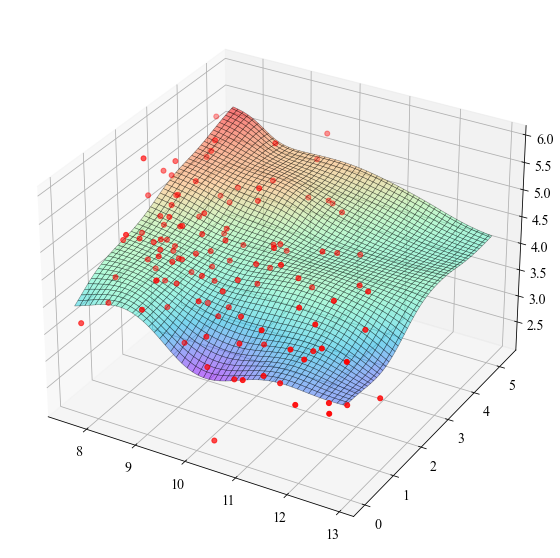

In [58]:
# target - dependent variable
# grid - grid for covariates
sample = covariates.values

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred)
ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r")

### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).

    As we could see, 3d points are quite widespread from our regression surface. In my opinion, it's caused by simplicity of our model. It also explains, why CIs are so wide.

# Task 3. Model Selection (5.5 pt)

In this task you will select a model (choose a set of covariates) using AIC criteria and forward/backward stepwise regression.

### Data loading and preprocessing

Read dataset `pacn_wrcc.csv`. The target variable is `ly Solar Rad.`, others are covariates.

In [59]:
df = pd.read_csv('pacn_wrcc.csv')

In [60]:
target = 'ly Solar Rad.'
df[target].head(3)

0    5.748000
1    0.218700
2    0.007225
Name: ly Solar Rad., dtype: float64

Scale covariates to range `[0, 1]` and add bias column.

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
scaler = StandardScaler()

In [63]:
tmp = df.columns.values.tolist()
tmp.remove(target)
covariates = tmp

In [64]:
df[covariates] = scaler.fit_transform(df[covariates])
covariates += ['bias']
df['bias'] = 1.
df[covariates].head(3)

,mph Wind Speed,Deg Wind Direc,Deg F Av Air Temp,% Rel Humidty,volts Battery Voltage,Deg Dir MxGust,mph Mx Gust Speed,Deg F Mn Air Temp,Deg F Mx Air Temp,"Deg F 2"" Soil Ave Tmp","Deg F 4"" Soil Ave Tmp","Deg F 8"" Soil Av Temp","Deg F 20""Soil Av Temp",bias
0,0.309990,-0.363457,0.379263,-0.067394,-0.710535,-0.789658,0.672202,0.580545,0.125365,0.833300,-0.127173,0.289086,-0.392978,1.0
1,0.214613,-0.507977,0.164560,0.388861,-1.222486,-1.198132,0.709290,0.241310,-0.043199,0.595198,-0.029096,-0.083048,-0.814027,1.0
2,0.503098,-0.464065,-0.084223,0.160734,-1.411100,-0.081634,2.184279,0.169472,-0.293237,0.342880,0.003596,-0.231901,-0.989464,1.0


In [65]:
X, y = df[covariates], df[target]

### $C_p$ Mallow and sample variance (2 pt) 

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

In [66]:
import seaborn as sns

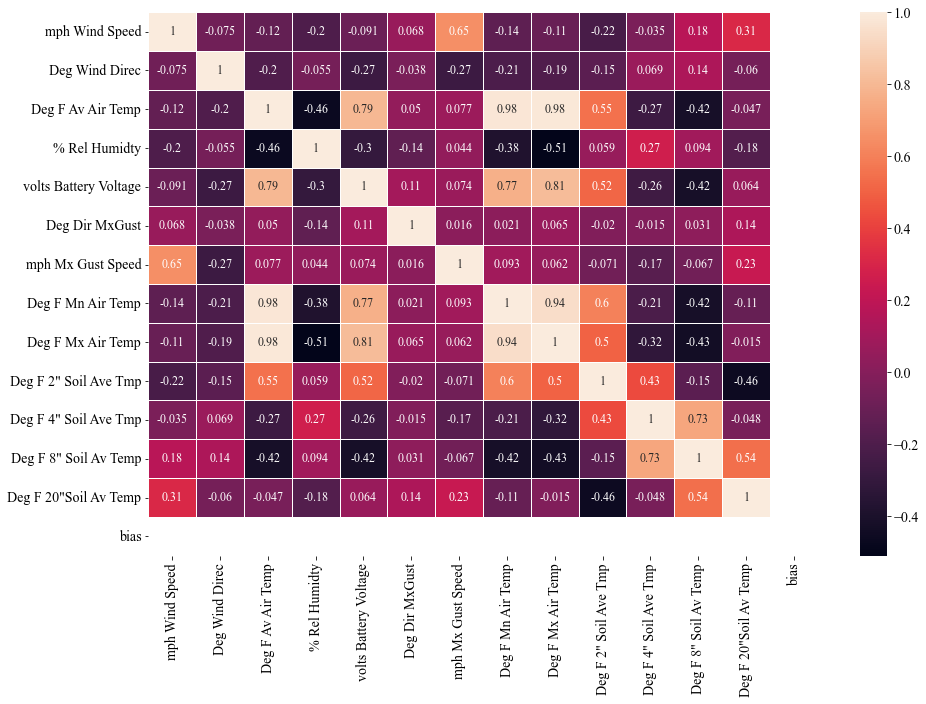

In [67]:
plt.figure(figsize=(15, 10))

sns.heatmap(df[covariates].corr(), annot=True, linewidths=.5)

plt.show()

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [69]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)

LinearRegression(fit_intercept=False)

In [70]:
y_pred = lin_reg.predict(X)

In [71]:
np.var(y_pred - y)

27.20973431088725

In [72]:
sigma2 = 1 / (df[covariates].shape[0] - 2) * np.sum((y_pred - y)**2)
sigma2

27.392349977403267

Implement estimation of $C_p$ Mallow for given covariates, target and error variance.

In [73]:
def Cp(X, y, sigma2):
    
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X, y)
    
    y_pred = lin_reg.predict(X)
    
    pred_risk = np.sum((y_pred - y)**2) 

    return pred_risk + 2 * X.shape[1] * sigma2

In [74]:
Cp(X, y, sigma2)

8929.906092633466

### Forward stepwise regression (1 pt)

Implement forward stepwise regression. Save the order in which covariates are added to feature set and $C_p$ values for those feature sets.

In [75]:
X, y = df[covariates], df[target]

In [76]:
def forward_stepwise_regression(X, y, sigma2, alpha=0.):
    
    risks = []
    for feat_id, _ in enumerate(X):
        risks.append(Cp(X.iloc[:, feat_id].values.reshape(-1, 1), y, sigma2))
    
    features = [np.argmin(risks)]
    cp_list = [risks[features[0]]]
    
    risk = cp_list[0]
    
    min_risk = 1e8
    
    while min_risk - risk > 0.0:
        
        min_risk = min(min_risk, risk)
        
        risks = []
        
        for feat_id, _ in enumerate(X):
                
            features.append(feat_id)
            risks.append(Cp(X.iloc[:, features], y, sigma2))
            features.pop()
        
        risk = np.min(risks)
        min_id = np.argmin(risks)
        if risk < min_risk and min_id not in features:
            features.append(min_id)
            cp_list.append(risk)
    
    return features, cp_list

In [77]:
features, cp_list = forward_stepwise_regression(X, y, sigma2)
for a, cp_value in enumerate(cp_list, 1):
    print(f"C_p {cp_value:.3f} +{features[:a]}")

C_p 58828.421 +[8]
C_p 19092.850 +[8, 13]
C_p 16574.144 +[8, 13, 10]
C_p 14542.671 +[8, 13, 10, 4]
C_p 12037.348 +[8, 13, 10, 4, 3]
C_p 10195.360 +[8, 13, 10, 4, 3, 6]
C_p 9673.790 +[8, 13, 10, 4, 3, 6, 2]
C_p 9054.602 +[8, 13, 10, 4, 3, 6, 2, 7]
C_p 9000.049 +[8, 13, 10, 4, 3, 6, 2, 7, 1]


### Backward stepwise regression (1 pt)

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and $C_p$ values for those feature sets.

In [78]:
def backward_stepwise_regression(X, y, sigma2, alpha=0.):
    
    min_risk = Cp(X, y, sigma2)
    
    features = np.array([x for x in range(X.shape[1])], dtype=int)
    
    mask = np.ones(X.shape[1], dtype=np.bool_)
    
    risks = []
    for feat_id, _ in enumerate(X):
        mask[feat_id] = False
        risks.append(Cp(X.iloc[:, features[mask]], y, sigma2))
        mask[feat_id] = True
    
    risk = np.min(risks)
    
    cp_list = []
    
    if risk < min_risk:
        cp_list = [risk]
        mask[np.argmin(risks)] = False
    else:
        return None, None
    
    while min_risk - risk > 0.0:
        
        min_risk = min(min_risk, risk)
        
        risks = []
        
        for feat_id, _ in enumerate(X):
            if mask[feat_id] == False:
                continue
            mask[feat_id] = False
            risks.append(Cp(X.iloc[:, features[mask]], y, sigma2))
            mask[feat_id] = True
        
        risk = np.min(risks)
        min_id = np.argmin(risks)
        
        if risk < min_risk:
            mask[min_id] = False
            cp_list.append(risk)

    return features[~mask], cp_list

In [79]:
features, cp_list = backward_stepwise_regression(X, y, sigma2)
for a, cp_value in enumerate(cp_list, 1):
    print(f"C_p {cp_value:.3f} +{features[:a]}")

C_p 8876.130 +[0]
C_p 8828.318 +[ 0 10]


### Bruteforce (1 pt)

Find best sets of covariates and their $C_p$ for all sizes of feature sets.

In [80]:
def bruteforce(X, y, sigma2, alpha=0.):
     
    min_risk = Cp(X, y, sigma2)
    
    features = np.array([x for x in range(X.shape[1])], dtype=int)
    
    best_features = [[] for x in range(X.shape[1])]
    
    cp_list = np.repeat(1e8, X.shape[1])
    
    for i in range(1, 2**X.shape[1]):
    
        num = bin(i)
        
        mask = np.array([d == '1' for d in num[2:].zfill(X.shape[1])], dtype=bool)
        
        risk = Cp(X.iloc[:, features[mask]], y, sigma2)
        
        old_min = cp_list[num.count('1') - 1]
        
        if risk < old_min:
            cp_list[num.count('1') - 1] = min(cp_list[num.count('1') - 1], risk)
            best_features[num.count('1') - 1] = features[mask]
    
    return best_features, cp_list

In [81]:
features, cp_list = bruteforce(X, y, sigma2)
for a, cp_value in enumerate(cp_list):
    print(f"C_p {cp_value:.3f} -{features[a]}")

C_p 58828.421 -[8]
C_p 19092.850 -[ 8 13]
C_p 16574.144 -[ 8 10 13]
C_p 13629.400 -[ 2  3  4 13]
C_p 11227.918 -[ 2  3  4 10 13]
C_p 9620.240 -[ 2  3  4  6 10 13]
C_p 9267.678 -[ 2  3  4  6  7 10 13]
C_p 9054.602 -[ 2  3  4  6  7  8 10 13]
C_p 9000.049 -[ 1  2  3  4  6  7  8 10 13]
C_p 8856.499 -[ 2  3  4  6  7  8  9 10 12 13]
C_p 8791.987 -[ 1  2  3  4  6  7  8  9 10 12 13]
C_p 8828.318 -[ 1  2  3  4  5  6  7  8  9 10 12 13]
C_p 8876.130 -[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
C_p 8929.906 -[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).

    We considered three different approaches for computing best LinReg estimate. Well, obviously, bruteforce allows us to see the whole picture, but the drawback is that complexity of it increases exponentionaly, depending of number of covariants. Although, it is still most verbose and informative and could be used, when number of covariants is not that huge. Well, considering two others, backward greedy approach executes faster and more precise.

# Task 4. Local regression (6 points)

In [82]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

In [83]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [84]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$
Lets fit a standard logistic regression to the data:

In [85]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

Coefficients of the fitted logistic regression model: b0=0.37698394684326253, b1=0.9109286874943998


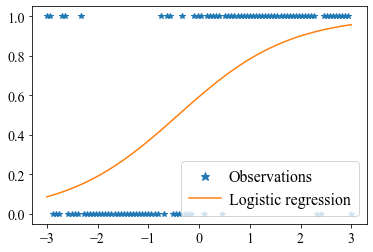

In [86]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logistic regression')
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model **at each new query point** $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closeness' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following **local** loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \log\frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically for each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package (2 points)
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation with log-likelihood as metric: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample (3 points)
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth (1 bonus point)

### 1)

In [87]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

Coefficients of the fitted logistic regression model: b0=0.37698394684326253, b1=0.9109286874943998


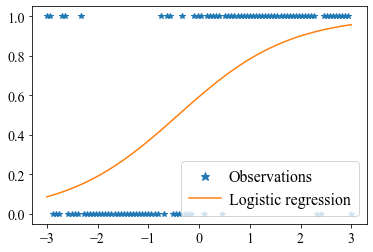

In [88]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logistic regression')
plt.legend()